In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [66]:
df = pd.read_csv("C:\\Users\\magshimim\\Desktop\\jupiter\\fashion-mnist_train.csv")

In [67]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After getting the dataset lets split it to the labels and the data itself

In [68]:
labels = df.label.values
labels

array([2, 9, 6, ..., 8, 8, 7], dtype=int64)

In [69]:
data = df.drop(['label'],axis = 1).values
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Reshape data to correct dimensions

In [70]:
data_to_show = data.reshape(-1,28,28,1)

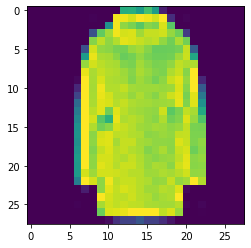

In [72]:
plt.imshow(data_to_show[6])

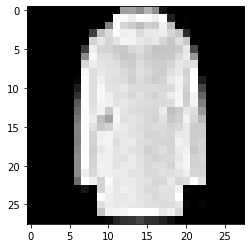

In [73]:
plt.imshow(data_to_show[6],cmap = plt.get_cmap("gray"))

In [74]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
data_train, data_test, target_train, target_test = train_test_split(data, labels,test_size = 0.05, random_state=10)

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
RFC = KNeighborsClassifier(n_neighbors = 20)
RFC.fit(data_train, target_train)

KNeighborsClassifier(n_neighbors=20)

In [76]:
pred = RFC.predict(data_test)
train = RFC.predict(data_train)
print(metrics.accuracy_score(target_test,pred))
print(metrics.accuracy_score(target_train,train))

0.8496666666666667
0.8599122807017544
